In [22]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy

In [23]:
# include points from either side of the intense point
MS1_PEAK_DELTA = 0.1

In [78]:
experiment_base_dir = '/Users/darylwilding-mcbride/Downloads/experiments'
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
precursor_id = 12291

download the cuboid ZIP file from the Google Cloud Console using the filter 'exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-precursor-{id}-'.

In [79]:
CUBOID_DIR = '/Users/darylwilding-mcbride/Downloads/exp-{}-run-{}-precursor-{}-of-52464'.format(EXPERIMENT_NAME, RUN_NAME, precursor_id)
CUBOID_MS1_FILE = '{}/exp-{}-run-{}-precursor-{}-cuboid-points-ms1-df.pkl'.format(CUBOID_DIR, EXPERIMENT_NAME, RUN_NAME, precursor_id)
CUBOID_METADATA_FILE = '{}/exp-{}-run-{}-precursor-{}-cuboid-metadata.json'.format(CUBOID_DIR, EXPERIMENT_NAME, RUN_NAME, precursor_id)

In [80]:
before_df = pd.read_pickle(CUBOID_MS1_FILE)
before_df['normalised_intensity'] = before_df.intensity / before_df.intensity.max()
metadata_s = pd.read_json(CUBOID_METADATA_FILE, orient='records', typ='series')

In [81]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

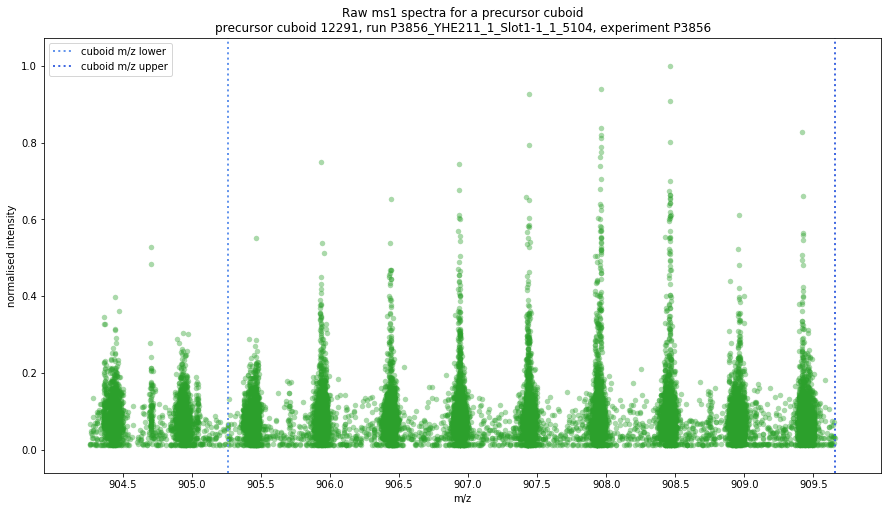

In [82]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

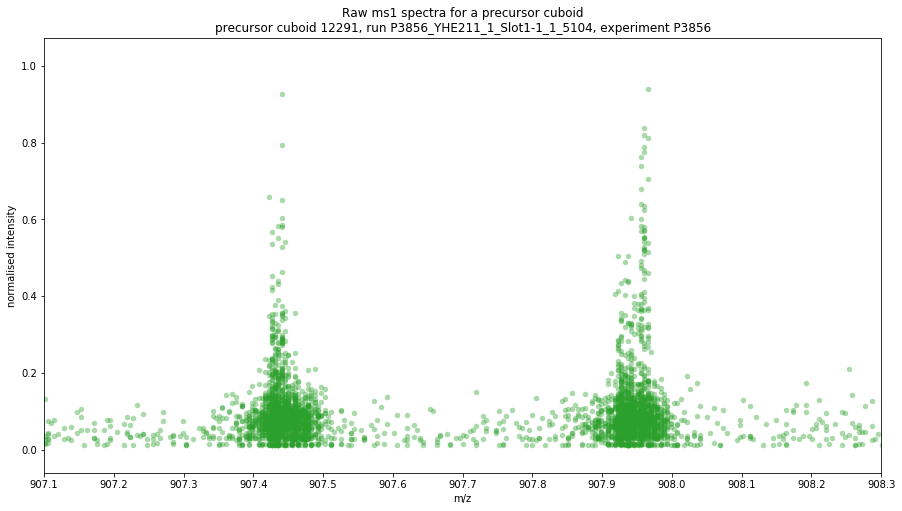

In [100]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.1
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlim((907.1,908.3))

plt.margins(0.06)
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [84]:
# fe_raw_points_df = before_df[(before_df.mz >= metadata_s.window_mz_lower) & (before_df.mz <= metadata_s.window_mz_upper) & (before_df.frame_id >= metadata_s.fe_ms1_frame_lower) & (before_df.frame_id <= metadata_s.fe_ms1_frame_upper)]
fe_raw_points_df = before_df[(before_df.mz >= metadata_s.wide_mz_lower) & (before_df.mz <= metadata_s.wide_mz_upper) & (before_df.frame_id >= metadata_s.fe_ms1_frame_lower) & (before_df.frame_id <= metadata_s.fe_ms1_frame_upper)]
fe_raw_points_a = fe_raw_points_df[['mz','intensity']].to_numpy()

In [85]:
def calculate_ms1_peak_delta(mz):
    instrument_resolution = 40000
    delta_m = mz / instrument_resolution  # FWHM of the peak
    sigma = delta_m / 2.35482  # std dev is FWHM / 2.35482. See https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    ms1_peak_delta = 3 * sigma  # 99.7% of values fall within +/- 3 sigma
    return ms1_peak_delta

In [86]:
calculate_ms1_peak_delta(1483)

0.04723290952174688

In [87]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [88]:
# ms1_peaks_a is a numpy array of [mz,intensity]
# returns a numpy array of [mz_centroid,summed_intensity]
def ms1_intensity_descent(ms1_peaks_a, ms1_peak_delta):
    # intensity descent
    ms1_peaks_l = []
    while len(ms1_peaks_a) > 0:
        # find the most intense point
        max_intensity_index = np.argmax(ms1_peaks_a[:,1])
        peak_mz = ms1_peaks_a[max_intensity_index,0]
        peak_mz_lower = peak_mz - ms1_peak_delta
        peak_mz_upper = peak_mz + ms1_peak_delta

        # get all the raw points within this m/z region
        peak_indexes = np.where((ms1_peaks_a[:,0] >= peak_mz_lower) & (ms1_peaks_a[:,0] <= peak_mz_upper))[0]
        if len(peak_indexes) > 0:
            mz_cent = mz_centroid(ms1_peaks_a[peak_indexes,1], ms1_peaks_a[peak_indexes,0])
            summed_intensity = ms1_peaks_a[peak_indexes,1].sum()
            ms1_peaks_l.append((mz_cent, summed_intensity))
            # remove the raw points assigned to this peak
            ms1_peaks_a = np.delete(ms1_peaks_a, peak_indexes, axis=0)
    return np.array(ms1_peaks_l)

In [89]:
peaks_fixed_bins_a = ms1_intensity_descent(fe_raw_points_a, 0.1)
peaks_fixed_bins_df = pd.DataFrame(peaks_fixed_bins_a, columns=['mz','intensity'])
peaks_fixed_bins_df['normalised_intensity'] = peaks_fixed_bins_df.intensity / peaks_fixed_bins_df.intensity.max()

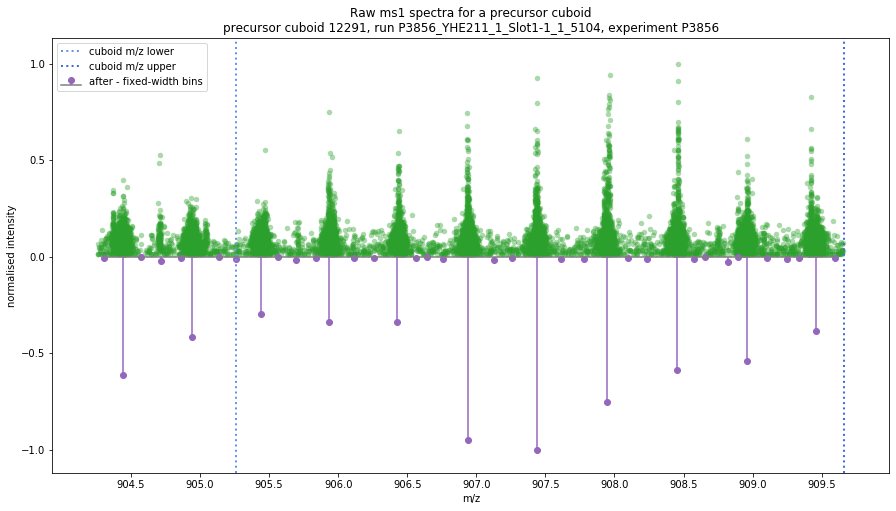

In [104]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_fixed_bins_df.mz, -peaks_fixed_bins_df.normalised_intensity, use_line_collection=True, label='after - fixed-width bins')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

# plt.xlim((1481,1482))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

#### plot the features after deconvolution of the fixed-width binned data

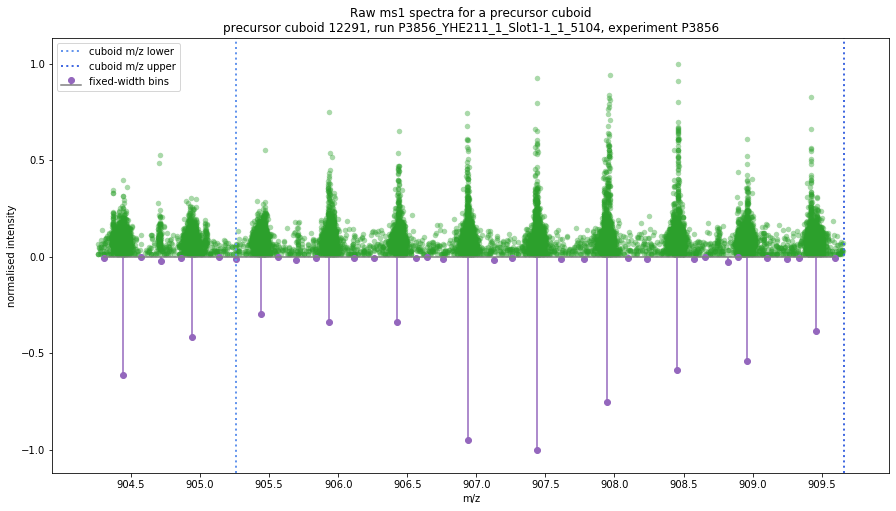

In [105]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_fixed_bins_df.mz, -peaks_fixed_bins_df.normalised_intensity, use_line_collection=True, label='fixed-width bins')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:grey')

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [92]:
ms1_peaks_l = list(map(tuple, peaks_fixed_bins_a))
deconvoluted_peaks, _priority_targets = deconvolute_peaks(ms1_peaks_l, use_quick_charge=True, averagine=averagine.peptide, charge_range=(1,5), error_tolerance=5.0, scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

In [93]:
ms1_deconvoluted_peaks_l = []
for peak_idx,peak in enumerate(deconvoluted_peaks):
    # discard a monoisotopic peak that has either of the first two peaks as placeholders (indicated by intensity of 1)
    if ((len(peak.envelope) >= 3) and (peak.envelope[0][1] > 1) and (peak.envelope[1][1] > 1)):
        mono_peak_mz = peak.mz
        mono_intensity = peak.intensity
        second_peak_mz = peak.envelope[1][0]
        ms1_deconvoluted_peaks_l.append((mono_peak_mz, second_peak_mz, mono_intensity, peak.score, peak.signal_to_noise, peak.charge, peak.envelope))
features_fixed_bins_df = pd.DataFrame(ms1_deconvoluted_peaks_l, columns=['mono_mz','second_peak_mz','intensity','score','SN','charge','envelope'])

In [94]:
features_fixed_bins_df

,mono_mz,second_peak_mz,intensity,score,SN,charge,envelope
0,904.559748,905.563103,421.000000,12.612174,140.333333,1,"((904.5754, 45.00), (905.5631, 123.00), (906.5..."
1,904.862185,905.840072,400.000000,11.853940,200.000000,1,"((904.8622, 198.00), (905.8401, 202.00), (906...."
2,904.214553,904.716231,1554.000000,18.932803,518.000000,2,"((904.3011, 341.00), (904.7162, 809.00), (905...."
3,904.438905,904.943719,61592.000000,344.292854,15398.000000,2,"((904.4389, 22678.00), (904.9437, 15356.00), (..."
4,906.253553,906.755230,1526.000000,34.475630,381.500000,2,"((906.2579, 369.00), (906.7552, 405.00), (907...."
5,906.941036,907.442714,121945.000000,474.243300,30486.250000,2,"((906.9367, 35235.00), (907.4427, 37017.00), (..."
6,907.107817,907.609495,1375.000000,27.126846,458.333333,2,"((907.1297, 648.00), (907.6095, 467.00), (908...."
7,908.453453,908.959923,45783.728905,224.161327,14133.250000,2,"((908.4530, 10994.73), (908.9599, 20122.00), (..."
8,905.683905,905.934744,20845.330959,76.256709,5239.800000,4,"((905.6922, 618.00), (905.9347, 7265.33), (906..."


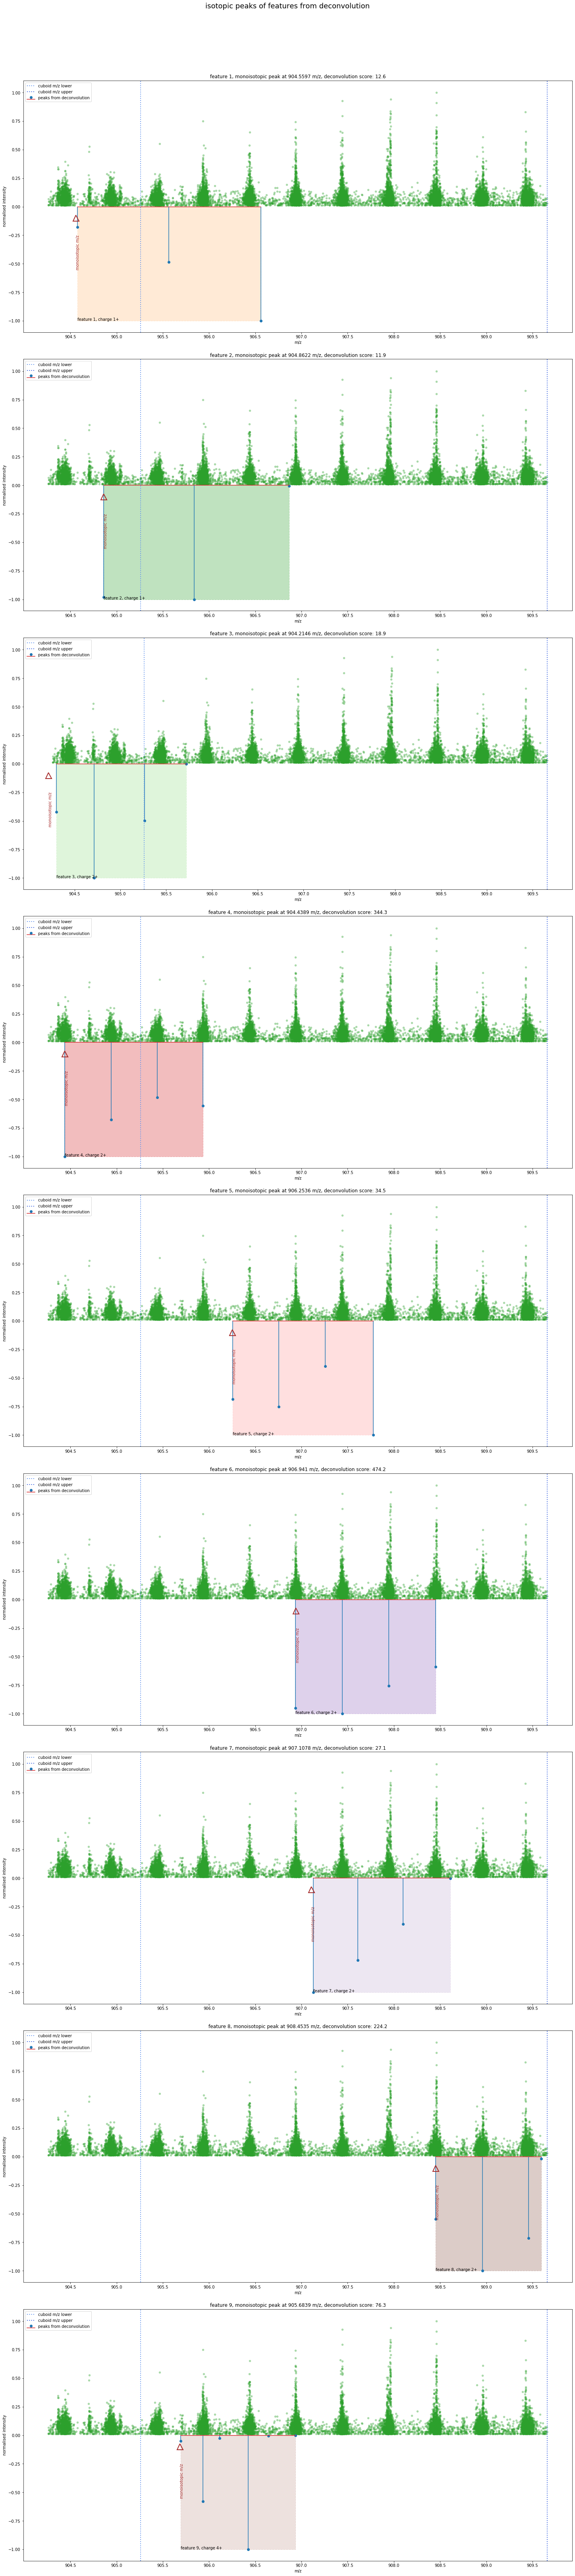

In [95]:
f, axarr = plt.subplots(nrows=len(features_fixed_bins_df), ncols=1, constrained_layout=True)
f.suptitle('isotopic peaks of features from deconvolution\n', fontsize=18)

f.set_figheight(len(features_fixed_bins_df)*10)
f.set_figwidth(20)

# plot the features derived from deconvoluting the peaks
for idx,row in enumerate(features_fixed_bins_df.itertuples()):
    if len(features_fixed_bins_df) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

    # plot the feature's bounding rectangle
    envelope = row.envelope
    feature_id = idx+1
    env_width = envelope[-1][0] - envelope[0][0]
    rect_colour = tableau20_mpl[idx+3]
    rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
    ax.add_patch(rect)
    ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(feature_id, row.charge))

    # determine the peaks from the envelope
    envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
    envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

    # plot the peaks from deconvolution
    markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, use_line_collection=True, label='peaks from deconvolution')
    
    # show the monoisotopic m/z determined by deconvolution
    ax.plot(row.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
    text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
    ax.text(row.mono_mz, -0.4, "monoisotopic m/z", **text_style, rotation='vertical')

    ax.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
    ax.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

    nearest = 0.5
    range_l = round(before_df.mz.min() / nearest) * nearest
    range_u = round(before_df.mz.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('m/z')
    ax.set_ylabel('normalised intensity')
    ax.legend(loc='best')
    
    ax.set_title('feature {}, monoisotopic peak at {} m/z, deconvolution score: {}'.format(feature_id, round(row.mono_mz,4), round(row.score,1)))

plt.show()